# Data Analysis Interview Challenge (Ultimate Inc.)

In [34]:
# Managing warnings
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import math

import json
from pandas.io.json import json_normalize

# Plot the Figures Inline
%matplotlib inline

In [2]:
## display option
pd.set_option('display.max_columns', None)

In [3]:
## missing values
missing_values = ['n/a', 'na', '-', '*']

# Part 1. Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute
time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [4]:
#timestamps of user logins in a particular geographic location
df_logins = pd.read_json('data/logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df_logins.shape

(93142, 1)

In [6]:
print("min time: {}".format(df_logins.login_time.min()))
print("max time: {}".format(df_logins.login_time.max()))

min time: 1970-01-01 20:12:16
max time: 1970-04-13 18:57:38


In [7]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [8]:
#Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex for using resample(), NOT RangeIndex
df_logins = df_logins.set_index('login_time')

In [9]:
# aggregate login counts based on 15-minute time intervals
df_logins['count_fifteenMin'] = 0
df_logins = df_logins.resample('15min').count()
df_logins.head()

,count_fifteenMin
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [10]:
#DatetimeIndex
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
count_fifteenMin    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


In [11]:
df_logins = df_logins.reset_index()

In [12]:
#RangeIndex
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 2 columns):
login_time          9788 non-null datetime64[ns]
count_fifteenMin    9788 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 153.0 KB


Visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles.

### Seasonal

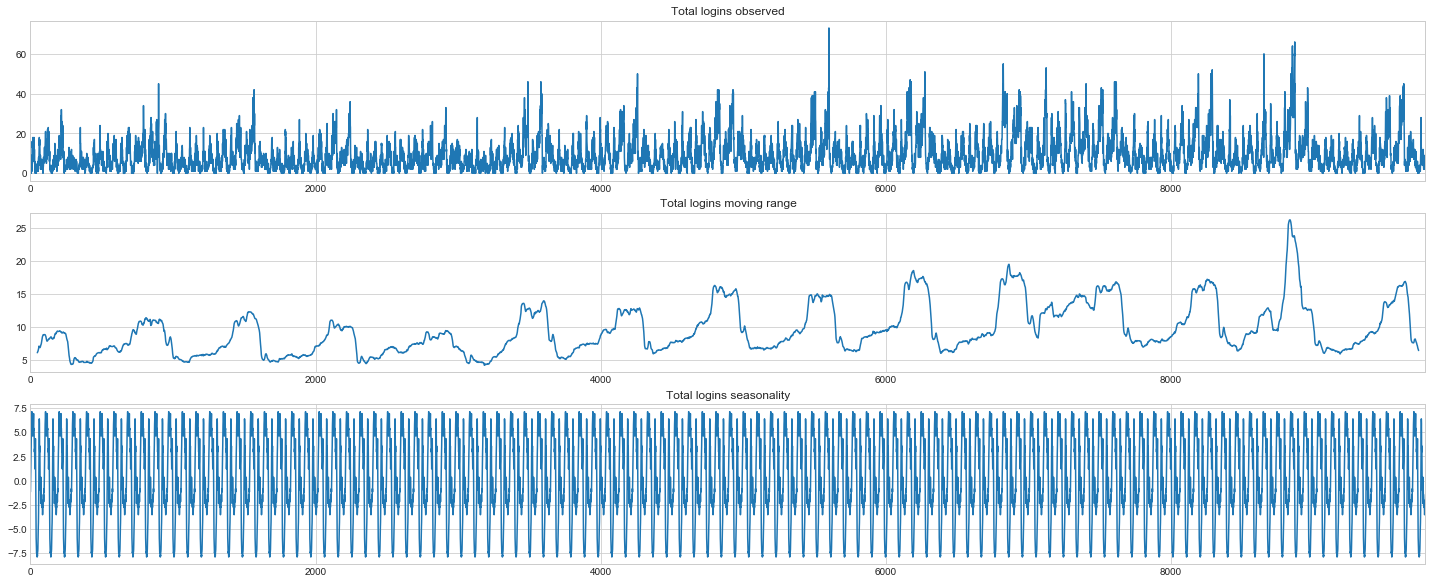

In [13]:
#Create a correlation plot of both datasets.
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 
season = seasonal_decompose(df_logins['count_fifteenMin'], model='additive', freq=96)

plt.subplot(3, 1, 1)
plt.title('Total logins observed')
season.observed.plot()

plt.subplot(3, 1, 2)
plt.title('Total logins moving range')
season.trend.plot()

plt.subplot(3, 1, 3)
plt.title('Total logins seasonality')
season.seasonal.plot()

It seems there are some patterns but it is hard to interpret. To look closer, the hourly and daily patterns of logins are investigated. 

### Week Day

In [14]:
# The day of the week with Monday=0, Sunday=6.
#df_logins['weekday']=df_logins['login_time'].dt.weekday #weekday = dayofweek (alias)
# names for ease of reference
#df_dayweek.weekday = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']


df_logins['weekday']=df_logins['login_time'].dt.day_name() #weekday = dayofweek (alias)
df_logins.head()

,login_time,count_fifteenMin,weekday
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday


In [15]:
# groupby('key', as_index=False): key does not become index but a column (no need reset_index() later)
df_dayweek = df_logins.groupby('weekday', as_index=False).sum()
df_dayweek

,weekday,count_fifteenMin
0,Friday,15208
1,Monday,8823
2,Saturday,19377
3,Sunday,18167
4,Thursday,11960
5,Tuesday,9268
6,Wednesday,10339


Text(0.5, 1.0, 'Logins by Day of Week')

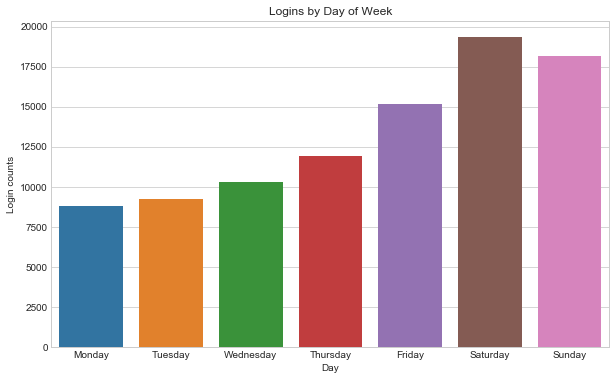

In [16]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,6)) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# bar plot
sns.barplot(x = 'weekday', y = 'count_fifteenMin', data = df_dayweek, order=weekday_order)
plt.xlabel('Day')
plt.ylabel('Login counts')
plt.title('Logins by Day of Week')

In [17]:
df_logins['hour'] = df_logins['login_time'].dt.hour
df_logins.head()

,login_time,count_fifteenMin,weekday,hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


In [18]:
df_hour = df_logins.groupby('hour', as_index=False).sum()
df_hour.head()

,hour,count_fifteenMin
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


Text(0.5, 1.0, 'Logins by Hour')

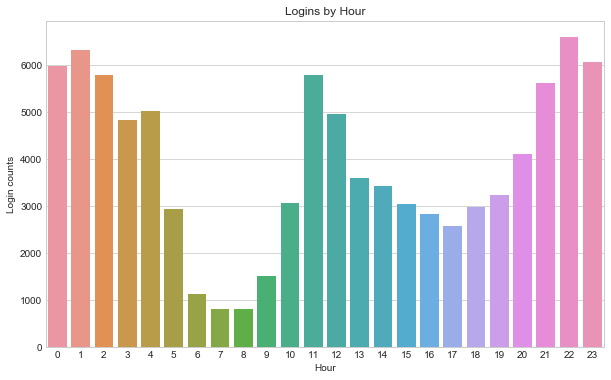

In [19]:
fig = plt.figure(figsize=(10,6))
# bar plot
sns.barplot(x = 'hour', y = 'count_fifteenMin', data = df_hour)
plt.xlabel('Hour')
plt.ylabel('Login counts')
plt.title('Logins by Hour')

In [20]:
# def dateplot(x, y, **kwargs):
#     ax = plt.gca()
#     data = kwargs.pop("data")
#     data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)
    
# g = sns.FacetGrid(df_logins, col="weekday", col_wrap=3, height=3.5)
# g = g.map_dataframe(dateplot, "hour", "count_fifteenMin")

In [21]:
df_day_hour = df_logins.groupby(['weekday','hour'], as_index=False).sum()
df_day_hour.head()

,weekday,hour,count_fifteenMin
0,Friday,0,975
1,Friday,1,957
2,Friday,2,771
3,Friday,3,502
4,Friday,4,353


* Pandas - How to group-by and plot for each hour of each day of week  
https://stackoverflow.com/questions/54856726/pandas-how-to-group-by-and-plot-for-each-hour-of-each-day-of-week

<Figure size 2016x1008 with 0 Axes>

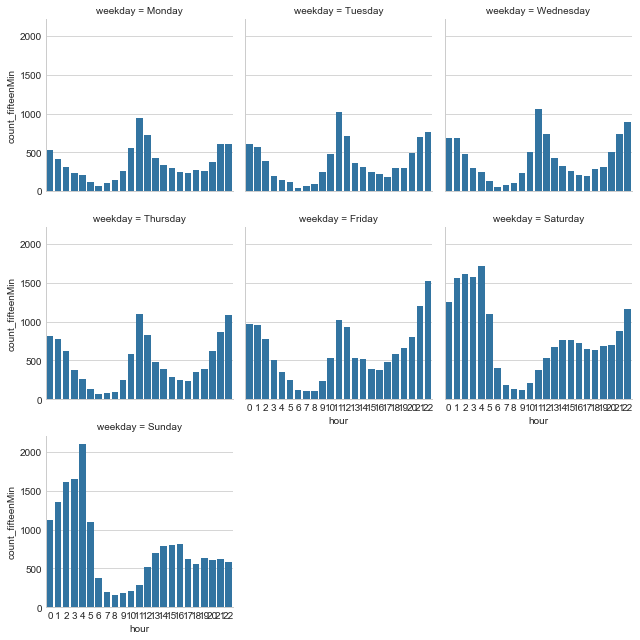

In [31]:
fig = plt.figure(figsize=(28,14))
g = sns.FacetGrid(df_day_hour, col="weekday", col_wrap=3, col_order=weekday_order)
g.map(sns.barplot, "hour", "count_fifteenMin", order=range(0,23))

## exact same approach
# g = sns.FacetGrid(data=df_logins.groupby(['weekday','hour']).count_fifteenMin.sum()
#                   .to_frame(name='day_hour_count').reset_index(), 
#                   col='weekday', 
#                   col_order=[
#     'Sunday',
#     'Monday',
#     'Tuesday',
#     'Wednesday',
#     'Thursday',
#     'Friday',
#     'Saturday'
# ], col_wrap=3)
# g.map(sns.barplot, 'hour', 'day_hour_count')

==> Summary:  

The logins most occur in Saturday and Sunday.

By investigating into hours, logins most occur at late night and  (21 ~ 2).
The logins start to increase from 21, peak at 22, decrease after 1.
During the lunch time (11 ~ 12), logins increase for a while.

**Combining weekdays and hours, we can see that most users log in most of the late nights and dawns on Sundays and Saturdays.**

# Part 2. Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?  

 ==> I want to investigate if the "encouraging driver partners (by reimbursing all toll costs)" is effective in servicing both cities.  
The most important key measure of success will be the **revenue increase** for the Ultimate Inc.
The higher the `increased revenue`, the experiment "encouraging driver partners to serve in both cities" can be considered to be more successful. Please note that the metrics are measured on before and after encouraging driver partners then the difference as the success indicator is obtained.
    - `increased revenue`: revenue (costs of toll reimbursement should be deducted)

 In the aspects of the servicing both cities, we can measure the following metrics that can be regarded to as successful indicators.

 - `increased number of available drivers`: average number of available drivers when calling for the pickup,  
 - `decreased wait time`: average wait time when calling for the pickup, and  
 - `increased number of trips`: number of trips across the bridges.


2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
  a. how you will implement the experiment  
  
 ==> To investigate the effectiveness of the proposed change, I would compare two groups of drivers with/without reimbursements and measure the key measures mentioned above.
I would recommend dividing the drivers at random by 50\% and 50\% for each group, 
one for the drivers offered reimbursement and the other for remaining drivers continuing to operate without being reimbursed for tolls. 

  b. what statistical test(s) you will conduct to verify the significance of the observation   
  
 ==> To verify the significance of the observation, I perform the A/B test on those two groups.
I perform the t-test with a confidence level of 95\%, where the null hypothesis is the reimbursing drivers for tolls does not have a statistically significant impact on Ultimate's net profits.

  c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.   
  
  ==> If the `increased revenue` is positive, then it is effective to encourage driver partners by reimbursing toll costs. If the `increased revenue` is negative, they should not adopt the toll cost reimbursement. Even it is revealed the `increased revenue` is positive, the drivers have randomly chosen, and it may not be effective in all cases. We need more rigorous experiments by different variables (e.g., selecting other drivers, differnt portions, different days, etc.)

# Part 3. Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.  

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention.

In [35]:
#users = pd.read_json('data/ultimate_data_challenge.json') #pd.read_json failed
#Then, open file, load with normal "json.load", then load into a pandas dataframe

with open('data/ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df_users = pd.DataFrame(data)
df_users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [36]:
df_users.shape

(50000, 12)

In [37]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


# Reference

http://benalexkeen.com/resampling-time-series-data-with-pandas/  
https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/